# `pygeostats` SNESIM

In [1]:
import numpy
import pygeostat as gs

from src.helpers.funcs import *

In [8]:
snesim_model = gs.Program(program="gan_bin\\snesim.exe")

for idx, im in enumerate(os.listdir("gan_bin/")):
    if im.endswith('.out'):
        par_string = f'''
                Parameters for SNESIM
                 ***********************

        START OF PARAMETERS:
        samples50.out             - file with original data
        1  2  3  4                    - columns for x, y, z, variable
        2                             - number of categories
        0   1                         - category codes
        0.7  0.3                      - (target) global pdf
        0                             - use (target) vertical proportions (0=no, 1=yes)
        vertprop.dat                  - file with target vertical proportions
        0                             - servosystem parameter (0=no correction)
        -1                            - debugging level: 0,1,2,3
        nsnesim.dbg                    - debugging file
        {im.split('.')[0]+'_snesim'}.out    - file for simulation output
        1                             - number of realizations to generate
        150    0.5    1.0             - nx,xmn,xsiz
        150    0.5    1.0             - ny,ymn,ysiz
        1     0.5    1.0              - nz,zmn,zsiz
        303258                        - random number seed
        30                            - max number of conditioning primary data
        10                            - min. replicates number
        0 0                           - condtion to LP (0=no, 1=yes), flag for iauto
        1.0 1.0                       - two weighting factors to combine P(A|B) and P(A|C)
        localprop.dat                 - file for local proportions
        0                             - condition to rotation and affinity (0=no, 1=yes)
        rotangle.dat                  - file for rotation and affinity
        3                             - number of affinity categories
        1.0  1.0  1.0                 - affinity factors (X,Y,Z)     
        1.0  0.6  1.0                 - affinity factors             
        1.0  2.0  1.0                 - affinity factors             
        6                             - number of multiple grids
        gan_bin/{im}          - file for training image
        150  150  1                   - training image dimensions: nxtr, nytr, nztr
        1                             - column for training variable
        10.0   10.0   5.0             - maximum search radii (hmax,hmin,vert)
        0.0    0.0   0.0              - angles for search ellipsoid
        '''
        #print(par_string)
        snesim_model.run(par_string)

Calling:  ['gan_bin\\snesim.exe', 'temp']

 SNESIM Version:   10.000

 Which parameter file do you want to use?
At line 322 of file snesim.f (unit = 5, file = 'stdin')
Fortran runtime error: End of file


In [4]:
file = read_conditional_samples("snesim/data/snesim_150x150.out")["D"]
realizations = file[:, 0].reshape(100, 150, 150)

eas: file ->snesim/data/snesim_150x150.out
eas: title-> SNESIM Realizations


# Reading image

In [5]:
import pygeostat as gs

from src.helpers.funcs import *

# Setting the cat dictionary
gs.Parameters['data.catdict'] = {1: 'Sandstone', 0: 'Shale'}
gs.Parameters.describe('data.catdict')

gs.Parameters['data.griddef'] = gs.GridDef([150, 0.5, 1.0,
                                            150, 0.5, 1.0,
                                            1.0, 0.5, 1.0])

# Default plot settings
gs.PlotStyle['font.size'] = 13
gs.PlotStyle['figure.figsize'] = (16, 9)

def highlight_cell(x_coordinate, y_coordinate, axis=None, **kwargs):
    rect = plt.Rectangle((x_coordinate - .5, y_coordinate - .5), 1, 1, fill=True, **kwargs)
    axis = axis or plt.gca()
    axis.add_patch(rect)
    return rect

data.catdict:
When initializing a DataFile, this dictionary will be used as DataFile.catdict (if catdict.keys() matches DataFile.cat codes). This dictionary is formaatted as {catcodes: catnames}.


In [7]:
import pandas as pd
from src.helpers.funcs import read_conditional_samples

conditioning_data = read_conditional_samples("snesim/data/samples50.out")["D"]

# Hard data
print("[INFO] Loading conditional data")

# Samples to dataframe
samples_im = pd.DataFrame()

samples_im['x'] = conditioning_data[:,0]
samples_im['y'] = conditioning_data[:,1]
samples_im['class'] = conditioning_data[:,3]

ti_dict = dict()

for idx, realization in enumerate(realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

dataframe = pd.DataFrame(ti_dict)
dataframe

eas: file ->snesim/data/samples50.out
eas: title->           eas title
[INFO] Loading conditional data


,ti_1,ti_2,ti_3,ti_4,ti_5,ti_6,ti_7,ti_8,ti_9,ti_10,...,ti_91,ti_92,ti_93,ti_94,ti_95,ti_96,ti_97,ti_98,ti_99,ti_100
0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22496,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22497,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22498,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


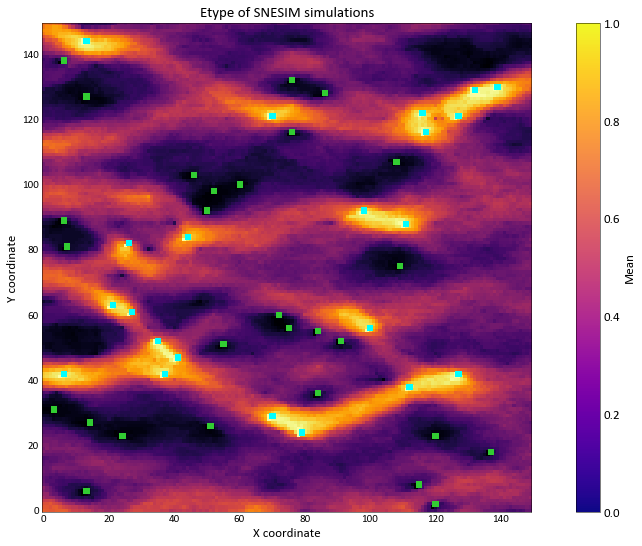

In [18]:
def etype_plot(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(16, 9))

    # Get mean for each row
    _data['etype'] = _data.mean(axis=1)
    plt.imshow(_data['etype'].values.reshape(150, 150),
               cmap='inferno', origin='lower')

    for row_sampled in samples_im.values:
        x, y, class_ = row_sampled[0], row_sampled[1], row_sampled[2]
        if class_== 0.:
            highlight_cell(x, y, color="limegreen", linewidth=3)
        else:
            highlight_cell(x, y, color="cyan", linewidth=3)

    # Text settings
    plt.title("Etype of SNESIM simulations", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Colorbar settings
    cmap = mpl.cm.plasma
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical', spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Mean", size=13)

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig("snesim/results/etype.pdf", dpi=500, bbox_inches="tight")
    plt.show()

# Limegreen is shale, Cyan is sand
etype_plot(dataframe)

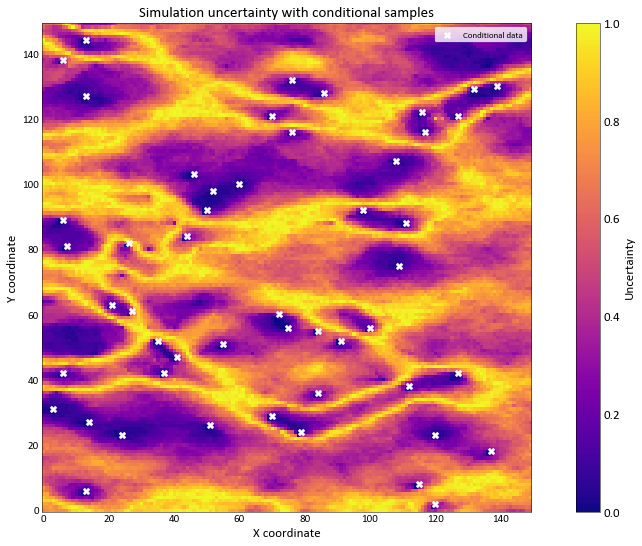

In [19]:
def calculate_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    _data['prob_sand'] = _data.sum(axis=1)
    _data['prob_shale'] = 100 - _data['prob_sand']

    _data["u_max"] = _data[["prob_shale", "prob_sand"]].max(axis=1) / 100
    _data["u_min"] = _data[["prob_shale", "prob_sand"]].min(axis=1) / 100

    _data.drop('prob_sand', axis=1, inplace=True)
    _data.drop('prob_shale', axis=1, inplace=True)

    return _data

def plot_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(16, 9))

    _data = calculate_uncertainty(_data)

    plt.imshow(_data['u_min'].values.reshape(150, 150),
              cmap='plasma', origin='lower')

    for row_sampled in samples_im.values:
        plt.scatter(row_sampled[0], row_sampled[1], marker='X',
                    color='white')

    # Legend and titles
    plt.legend(["Conditional data"], loc=0,
               frameon=True, fontsize=9)

    plt.title("Simulation uncertainty with conditional samples", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Colorbar settings
    cmap = mpl.cm.plasma
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Uncertainty", size=13)

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig('snesim/results/uncertainty.pdf', dpi=500, bbox_inches="tight")
    plt.show()

plot_uncertainty(dataframe)

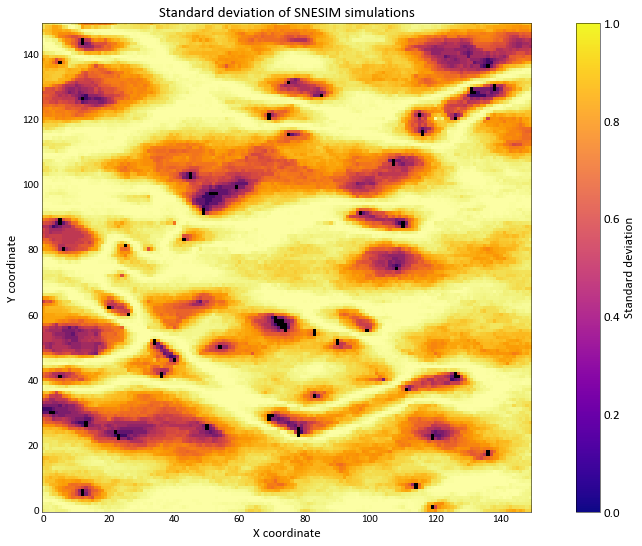

In [21]:
import matplotlib as mpl

def std_plot(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(16, 9))

    # Get mean for each row
    dataframe['std'] = dataframe.std(axis=1)
    plt.imshow(dataframe['std'].values.reshape(150, 150),
               cmap='inferno', origin='lower')

    # Set axis and plot titles
    plt.title("Standard deviation of SNESIM simulations", size=15)
    plt.xlabel("X coordinate", size=13)
    plt.ylabel("Y coordinate", size=13)

    # Set colorbar settings
    cmap = mpl.cm.plasma
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical', spacing="proportional")
    cb.ax.tick_params(labelsize=13)
    cb.set_label("Standard deviation", size=13)

    # Saving images to .pdf format
    plt.savefig("snesim/results/deviation.pdf", dpi=500,
                bbox_inches="tight")
    plt.grid(False)
    plt.show()

std_plot(dataframe)

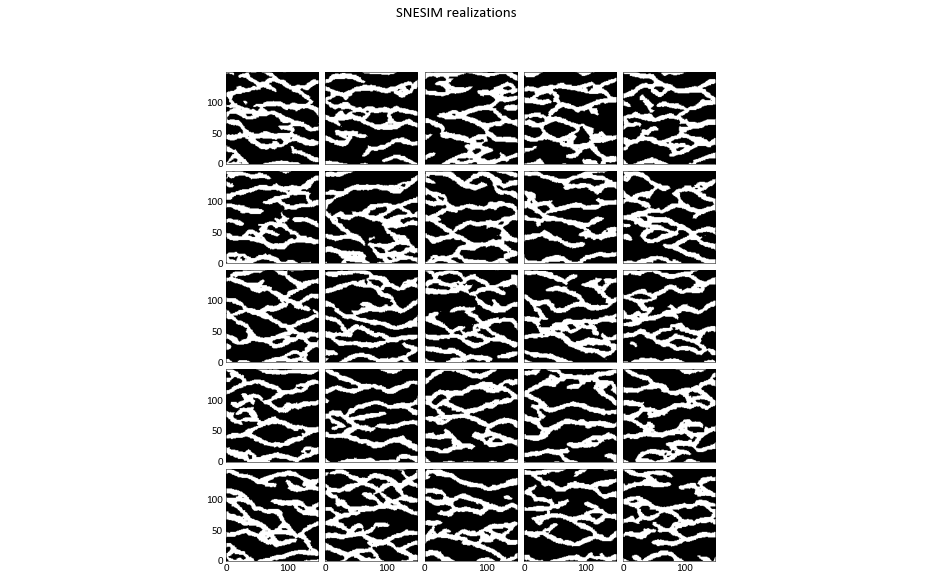

In [31]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_realizations_grid(real):
    # Samples 25 TI for a grid of 5x5 images
    rand_idx = [random.randint(0, 99) for _ in range(25)]
    tis_sampled = [real[i] for i in rand_idx]

    fig = plt.figure(figsize=(16, 9))
    image_grid = ImageGrid(fig, 111,  # similar to subplot(111)
                           nrows_ncols=(5, 5),  # creates 5x5 grid of axes
                           axes_pad=0.1,  # pad between axes in inch.
                           )

    for ax, image in zip(image_grid, tis_sampled):
        # Iterating over the grid returns the Axes.
        ax.imshow(image, cmap="gray", origin="lower")

    fig.suptitle("SNESIM realizations", fontsize=15)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

    #plt.xlabel("X coordinate", size=13)
    #plt.ylabel("Y coordinate", size=13)

    #fig.tight_layout()
    plt.savefig("snesim/results/simulation_grid.pdf", dpi=500,
                bbox_inches="tight")
    plt.show()

plot_realizations_grid(realizations)

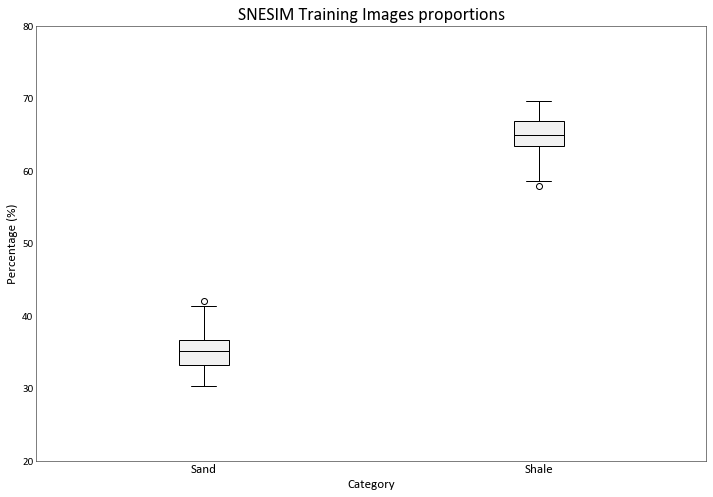

In [193]:
def get_sand_shale_proportion(image):
    image = image.reshape(-1)
    sand_prop = (len(np.where(image==1)[0]) / 150**2)*100
    shale_prop = (len(np.where(image==0)[0]) / 150**2)*100
    return sand_prop, shale_prop

def proportions(real: numpy.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(12, 8))

    sand_values = list()
    shale_values = list()

    # Get proportions for all
    for i in range(1, len(real)):
        sand, shale = get_sand_shale_proportion(real[i].reshape(-1))
        sand_values.append(sand)
        shale_values.append(shale)

    df_dict = dict(Sand=sand_values, Shale=shale_values)
    df = pd.DataFrame.from_dict(df_dict, orient='columns')

    # Boxplot
    bp = ax.boxplot(df, labels=["Sand", "Shale"], patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")

    for patch in bp['boxes']:
        patch.set(facecolor='#f1f1f1')

    plt.ylim(20, 80)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(13)

    plt.ylabel('Percentage (%)', size=13)
    plt.xlabel('Category', size=13)
    plt.title('SNESIM Training Images proportions', size=18)

    plt.savefig("snesim/results/boxplot_snesim.pdf", dpi=500,
                bbox_inches='tight')

    plt.show()

proportions(realizations)